# JOBS Data

Import of all needed libraries, numpy, pandas, matplot, sckitlearn, some will be used further on. 

## Packages and Files Import

In [1]:
!pip install econml

In [2]:
!wget "https://github.com/dmachlanski/CE888_2022/blob/main/project/data/jobs.npz?raw=true" -O "jobs.npz"
!wget "https://raw.githubusercontent.com/PauMarquez99/DataScience-CE888/Assignment2/Assignments/CE888%20Assignment%202/Datasets%20Notebooks/CE888-Functions.py" -O "functions.py"

--2022-04-28 07:54:54--  https://github.com/dmachlanski/CE888_2022/blob/main/project/data/jobs.npz?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/dmachlanski/CE888_2022/raw/main/project/data/jobs.npz [following]
--2022-04-28 07:54:54--  https://github.com/dmachlanski/CE888_2022/raw/main/project/data/jobs.npz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/jobs.npz [following]
--2022-04-28 07:54:54--  https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/jobs.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... con

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as f
import shap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from econml.dml import CausalForestDML

sns.set(font_scale=1.4)

## Data Analysis and Visualisation


In [4]:
df = np.load("jobs.npz")

df.files

['x', 't', 'y', 'e']

Quick check of missing values and shape. We are able to see that there are 3212 rows, and in "x" we notice is is a array of 17x3212, meaning there are 17 background features, while we also have those mentioned above including the labels and there are no missing values in the dataset.

In [5]:
for data in df.files:
  print(f'{data}: {df[data].shape}')

x: (3212, 17)
t: (3212, 1)
y: (3212, 1)
e: (3212, 1)


Data import and structure checking, we can see that we have background variables "x", treatment "t", outcome "y", and effect "e".

In this dataset we are able to see that it is closer to reality, as we don't have any counterfactuals, just the outcome, which happens to those datasets that are either purely observational or mixed with _Randomized Controlled Trials_. 

In [6]:
X = df['x']
T = df['t'].reshape(-1, 1)
Y = df['y'].reshape(-1, 1)
e = df['e']

In [7]:
for data in df.files:
  print(f'{data}: {df[data].shape}')

x: (3212, 17)
t: (3212, 1)
y: (3212, 1)
e: (3212, 1)


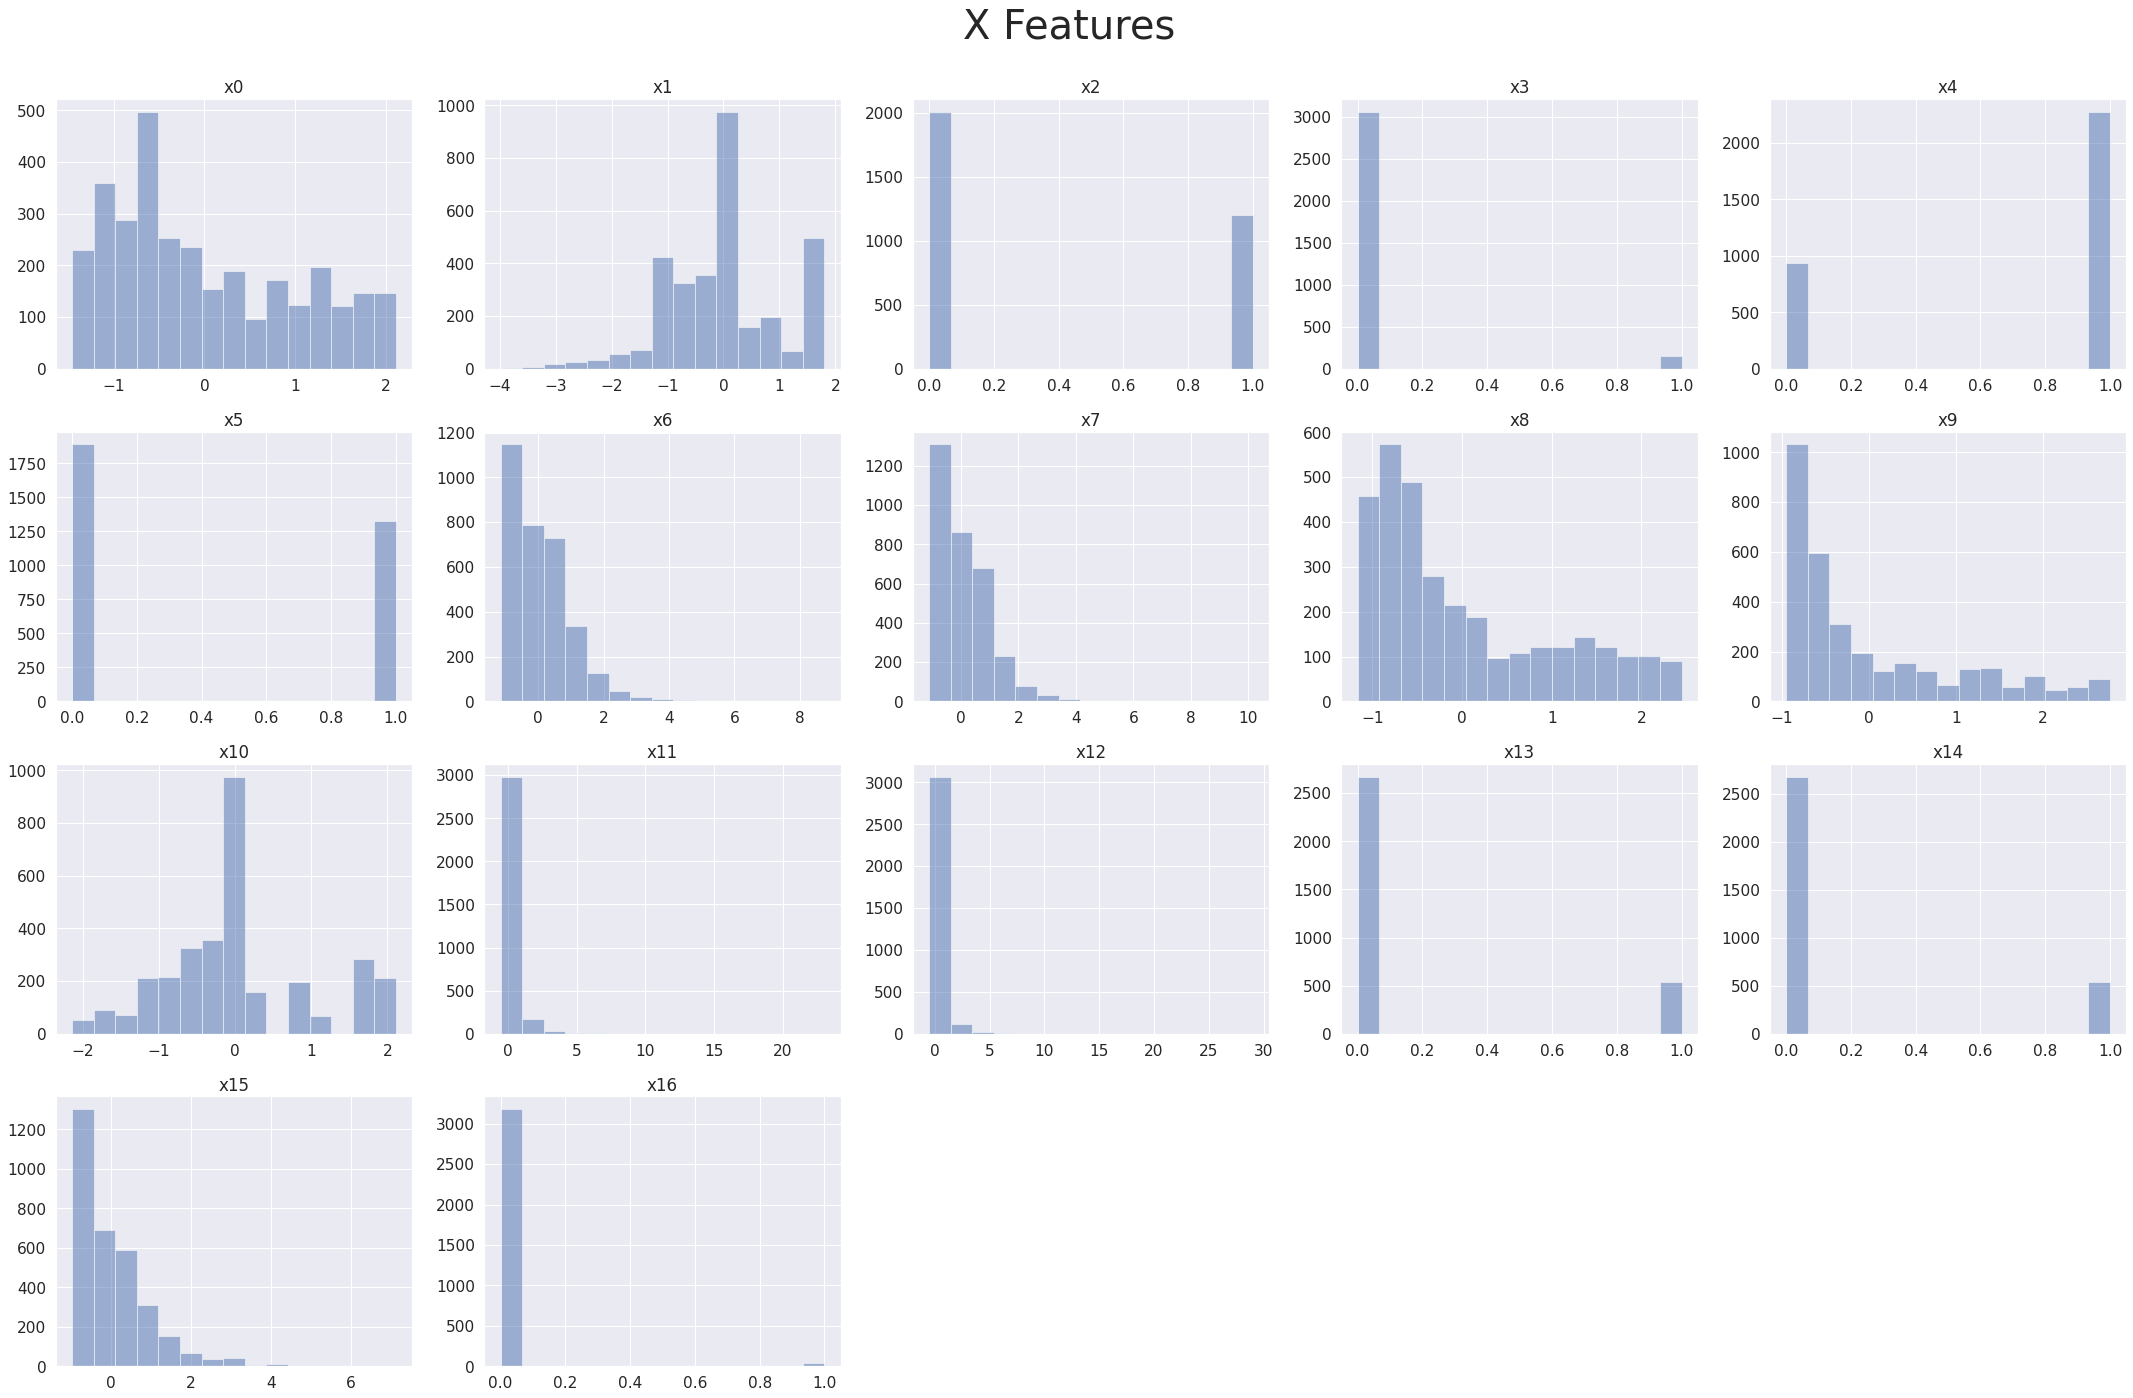

In [8]:
xName = ["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "x13", "x14", "x15", "x16"]
Xp = pd.DataFrame(data=X)
Xp.columns=xName

axes = Xp.hist(color='b', alpha=0.5, bins=15, figsize=(30,25), layout=(5, 5))
plt.suptitle("X Features", size=40)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("jobs_xFeatures.pdf", dpi=1500)


To have a better understandment of the behaviour of the data, we will plot it's histograms.

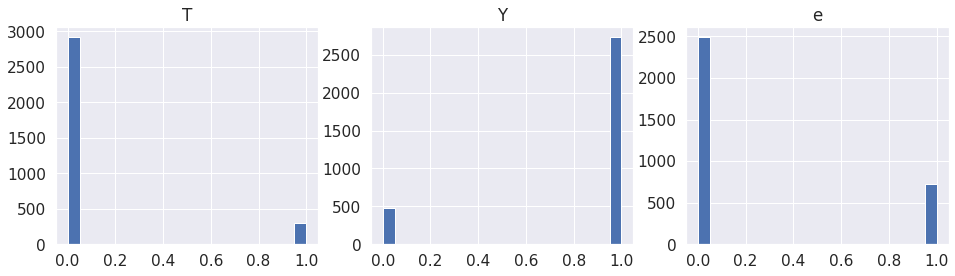

In [9]:
bins=20
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].hist(T, bins=bins)
axs[1].hist(Y, bins=bins)
axs[2].hist(e, bins=bins)
axs[0].title.set_text('T')
axs[1].title.set_text('Y')
axs[2].title.set_text('e')
sns.set()
plt.show()
fig.savefig("jobs_TreatmentAndElse.pdf", dpi=1200)

In [10]:
print("Amount of 0 in T: ", np.count_nonzero(df['t'] == 0))
print("Amount of 1 in T: ", np.count_nonzero(df['t'] == 1))

Amount of 0 in T:  2915
Amount of 1 in T:  297


In [11]:
print("Amount of 0 in Y: ", np.count_nonzero(df['y'] == 0))
print("Amount of 1 in Y: ", np.count_nonzero(df['y'] == 1))

Amount of 0 in Y:  482
Amount of 1 in Y:  2730


In [12]:
print("Amount of 0 in e: ", np.count_nonzero(df['e'] == 0))
print("Amount of 1 in e: ", np.count_nonzero(df['e'] == 1))

Amount of 0 in e:  2490
Amount of 1 in e:  722


In this case we are able to see that the "T", "Y" and "e" have a binary behaviour, and while it is noticeable using the variables histograms, a count was also printed to visualize in another way the differences in all 3 aspects. And further on we can establish that neither X nor Y follow a normal distribution.

## Preprocessing

In [13]:
x_train, x_rem, y_train, y_rem, t_train, t_rem, e_train, e_rem = train_test_split(X, Y, T, e, train_size=0.56)
x_valid, x_test, y_valid, y_test, t_valid, t_test, e_valid, e_test = train_test_split(x_rem, y_rem, t_rem, e_rem, test_size=0.45)

In [14]:
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_valid = scaler_x.transform(x_valid)
x_test = scaler_x.transform(x_test)

## Training

### Random Forest Classifier

In [15]:
from re import RegexFlag
rf = RandomForestClassifier()

# Train on the training data.
rf.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten())

# Training predictions:
rf_y0_in = rf.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
rf_y1_in = rf.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

# Validation predictions (model's generalisation to unseen examples):
rf_y0_out = rf.predict(np.concatenate([x_valid, np.zeros_like(t_valid)], axis=1))
rf_y1_out = rf.predict(np.concatenate([x_valid, np.ones_like(t_valid)], axis=1))

# Compute ITEs (training and validation)
# ITE = Y_1 - Y_0
rf_e_in = rf_y1_in - rf_y0_in
rf_e_out = rf_y1_out - rf_y0_out

rf_e_in=rf_e_in.reshape(-1,1)
rf_e_out=rf_e_out.reshape(-1,1)

#### Metrics

In [16]:
# Error on ATT

rf_att_in = f.abs_att(rf_e_in, y_train, t_train, e_train)
rf_att_out = f.abs_att(rf_e_out, y_valid, t_valid, e_valid)


# PR
rf_pr_in = f.policy_risk(rf_e_in, y_train, t_train, e_train)
rf_pr_out = f.policy_risk(rf_e_out, y_valid, t_valid, e_valid)

results = []
results.append(['RF', rf_att_in, rf_att_out, rf_pr_in, rf_pr_out])


### Hyperparameter Optimization

In [17]:
# Defines parameter search space for Random Forests.
params = {"max_leaf_nodes": [10, 20, 30, None], "n_estimators": [5, 15, 20], "max_features": ['auto', 'sqrt'],}

In [18]:
rfGS = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1, cv=5)

rfGS.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten())

rfGS_y0_in = rfGS.predict(np.concatenate([x_valid, np.zeros_like(t_valid)], axis=1))
rfGS_y1_in = rfGS.predict(np.concatenate([x_valid, np.ones_like(t_valid)], axis=1))

rfGS_y0_out = rfGS.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
rfGS_y1_out = rfGS.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

rfGS_e_in = rfGS_y1_in - rfGS_y0_in
rfGS_e_out = rfGS_y1_out - rfGS_y0_out

rfGS_e_in=rfGS_e_in.reshape(-1,1)
rfGS_e_out=rfGS_e_out.reshape(-1,1)

In [19]:
rfGS.best_params_

{'max_features': 'auto', 'max_leaf_nodes': 30, 'n_estimators': 20}

#### Metrics

In [20]:
#ATT

rfGS_att_in = f.abs_att(rfGS_e_in, y_valid, t_valid, e_valid)
rfGS_att_out = f.abs_att(rfGS_e_out, y_test, t_test, e_test)


# PR
rfGS_pr_in = f.policy_risk(rfGS_e_in, y_valid, t_valid, e_valid)
rfGS_pr_out = f.policy_risk(rfGS_e_out, y_test, t_test, e_test)

results.append(['RF-GS', rfGS_att_in, rfGS_att_out, rfGS_pr_in, rfGS_pr_out])


###  Propensity Scores

In [21]:
# Get the sample weights
prop_clf = RandomForestClassifier()
weights = f.get_ps_weights(prop_clf, x_train, t_train)

# Train the regressor
rf_ipsw = RandomForestRegressor()
rf_ipsw.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten(), sample_weight=weights)

# Make predictions
rf_ipsw_y0_in = rf_ipsw.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
rf_ipsw_y1_in = rf_ipsw.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

rf_ipsw_y0_out = rf_ipsw.predict(np.concatenate([x_valid, np.zeros_like(t_valid)], axis=1))
rf_ipsw_y1_out = rf_ipsw.predict(np.concatenate([x_valid, np.ones_like(t_valid)], axis=1))

rf_ipsw_e_in = rf_ipsw_y1_in - rf_ipsw_y0_in
rf_ipsw_e_out = rf_ipsw_y1_out - rf_ipsw_y0_out

rf_ipsw_e_in=rf_ipsw_e_in.reshape(-1,1)
rf_ipsw_e_out=rf_ipsw_e_out.reshape(-1,1)

#### Metrics

In [22]:
# Error on ATT

rf_ipsw_att_in = f.abs_att(rf_ipsw_e_in, y_train, t_train, e_train)
rf_ipsw_att_out = f.abs_att(rf_ipsw_e_out, y_valid, t_valid, e_valid)


# PR
rf_ipsw_pr_in = f.policy_risk(rf_ipsw_e_in, y_train, t_train, e_train)
rf_ipsw_pr_out = f.policy_risk(rf_ipsw_e_out, y_valid, t_valid, e_valid)

results.append(['RF IPSW', rf_ipsw_att_in, rf_ipsw_att_out, rf_ipsw_pr_in, rf_ipsw_pr_out])


### Hyperparameter Optimization

In [23]:
# Defines parameter search space for Random Forests.
params = {"max_leaf_nodes": [10, 20, 30, None], "n_estimators": [5, 15, 20], "max_features": ['auto', 'sqrt'],}

In [24]:
prop_clf = GridSearchCV(RandomForestClassifier(), param_grid=params, n_jobs=-1, cv=5)
weights = f.get_ps_weights(prop_clf, x_train, t_train)

rfGS_ipsw = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1, cv=5)
rfGS_ipsw.fit(np.concatenate([x_train, t_train], axis=1), y_train.flatten(), sample_weight=weights)

rfGS_ipsw_y0_in = rfGS_ipsw.predict(np.concatenate([x_train, np.zeros_like(t_train)], axis=1))
rfGS_ipsw_y1_in = rfGS_ipsw.predict(np.concatenate([x_train, np.ones_like(t_train)], axis=1))

rfGS_ipsw_y0_out = rfGS_ipsw.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
rfGS_ipsw_y1_out = rfGS_ipsw.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

rfGS_ipsw_e_in = rfGS_ipsw_y1_in - rfGS_ipsw_y0_in
rfGS_ipsw_e_out = rfGS_ipsw_y1_out - rfGS_ipsw_y0_out

rfGS_ipsw_e_in=rfGS_ipsw_e_in.reshape(-1,1)
rfGS_ipsw_e_out=rfGS_ipsw_e_out.reshape(-1,1)

In [25]:
rfGS_ipsw.best_params_

{'max_features': 'sqrt', 'max_leaf_nodes': 30, 'n_estimators': 20}

#### Metrics

In [26]:
#ATT

rfGS_ipsw_att_in = f.abs_att(rfGS_ipsw_e_in, y_train, t_train, e_train)
rfGS_ipsw_att_out = f.abs_att(rfGS_ipsw_e_out, y_test, t_test, e_test)


# PR
rfGS_ipsw_pr_in = f.policy_risk(rfGS_ipsw_e_in, y_train, t_train, e_train)
rfGS_ipsw_pr_out = f.policy_risk(rfGS_ipsw_e_out, y_test, t_test, e_test)

results.append(['RF IPSW -GS', rfGS_ipsw_att_in, rfGS_ipsw_att_out, rfGS_ipsw_pr_in, rfGS_ipsw_pr_out])


### Causal Forest DML

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please

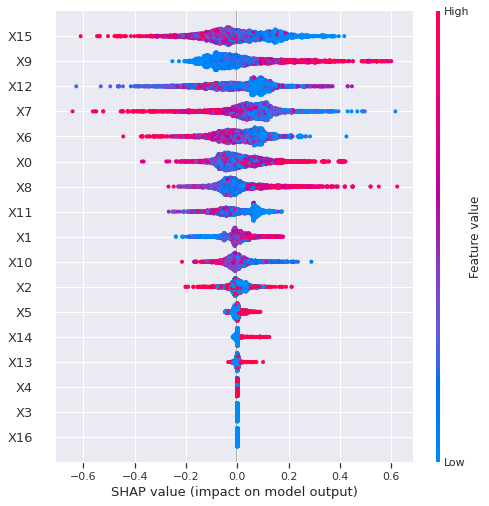

In [33]:
#DRLearner, SparseLinearDRLearner
cf = CausalForestDML()

# Train on the training data.
cf.fit(y_train, t_train, X=x_train, W=None)

effect_pred = cf.effect(x_test)
effect_int = cf.effect_interval(x_test)

# calculate shap values of causal forest model 
shap_values = cf.shap_values(X)
# plot shap values 
shap.summary_plot(shap_values['Y0']['T0'])
results.append(['CF'])

### Evaluation

In [28]:
cols = ['Method', 'ATT valid', 'ATT test', 'PR valid', 'PR test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATT valid,ATT test,PR valid,PR test
0,RF,22.246200,17.553019,0.246059,0.308832
1,RF-GS,0.055146,0.130364,0.231021,0.269657
2,RF IPSW,0.040497,0.011381,0.020615,0.263425
3,RF IPSW -GS,0.021384,0.144432,0.118524,0.221256
4,CF,NaN,NaN,NaN,NaN
